In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import utils

import os
import glob
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from enum import Enum

In [2]:
# 하이퍼파라메타 값 세팅
batch_size = 36
num_epochs = 20
val_every = 1 # 평가 간격
save_weights_dir = '.\\weights'
# 모델 가중치 저장할 폴더 생성
os.makedirs(save_weights_dir, exist_ok=True)
data_path = '.\\dataset'
nc = len(os.listdir(os.path.join(data_path, os.listdir(data_path)[0]))) # num_classes
lr = 0.025 # learning rate

In [3]:
# https://tutorials.pytorch.kr/beginner/finetuning_torchvision_models_tutorial.html

def initialize_model(model_name, num_classes, use_pretrained=True):
    
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        # Resnet18
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        # Alexnet
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        # VGG11_bn
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        # Squeezenet
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [4]:
class Mode(Enum):
    __dir = os.listdir(data_path)
    train = __dir[0] if 'train' in __dir[0].lower() else __dir[1]
    val = __dir[1 - __dir.index(train)]

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_path, mode: Mode, transform=None):
        self.labels = os.listdir(os.path.join(data_path, mode.value))
        self.all_data = sorted(glob.glob(os.path.join(data_path, mode.value, '*', '*.jpg')))
        self.all_data_dict = {label: sorted(glob.glob(os.path.join(data_path, mode.value, str(label), '*.jpg')))
                              for label in self.labels}
        self.transform = transform

    def __getitem__(self, index):
        images = Image.open(self.all_data[index]).convert('RGB')
        if self.transform is not None:
            images = self.transform(images)

        return images, self.labels.index(self.all_data[index].split('\\')[-2])

    def __len__(self):
        return len(self.all_data)

In [6]:
def data_augmentation():
    data_transform = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
        ])
    }
    return data_transform

In [7]:
def train_model(model, data_loaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    history = []
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    valid_acc = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
            else:
                valid_loss = epoch_loss
                valid_acc = epoch_acc

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

In [8]:
def visualize_loss_acc(history, optim):
    plt.figure(figsize=(20, 10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['valid_loss'], label='valid_loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(122)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['valid_acc'], label='valid_acc')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()
    # plt.savefig(str(path) + 'loss_acc.png')

In [9]:
def visualize_predict(model, data):
    c = np.random.randint(0, len(data))
    img, label = data[c]

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # out = model(img.view(1, 3, 224, 224).cuda())
        out = model(img.view(1, 3, 224, 224).cpu())
        out = torch.exp(out)
        # print(out)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1, 2, 0)).astype(np.uint8))
    plt.title(data.labels[label])
    plt.subplot(122)
    plt.barh(data.labels, out.cpu().numpy()[0])
    plt.show()

In [10]:
def visualize_class_accuracies(model, data):
    accuracy_dict = {}
    with torch.no_grad():
        model.eval()
        for c in data.all_data_dict.keys():
            total_count = len(data.all_data_dict[c])
            correct_count = 0
            for path in data.all_data_dict[c]:
                # print(path)
                im = Image.open(path).convert('RGB')
                # im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224, 224))(im)
                # out = model(im.view(1, 3, 224, 224).cuda())
                out = model(im.view(1, 3, 224, 224).cpu())
                # print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                # print(pred)
                pred = pred.index(max(pred))
                # print(pred, data.labels.index(c))

                if pred == data.labels.index(c):
                    correct_count += 1

            print(f"Accuracy for class {c} : ", correct_count / total_count)
            accuracy_dict[c] = correct_count / total_count

    plt.figure(figsize=(10, 5))
    plt.title('Class_accuracies')
    plt.barh(list(accuracy_dict.keys()), list(accuracy_dict.values()))
    plt.show()

    return accuracy_dict

In [11]:
def save_model(model, file_name="best.pt", save_dir=save_weights_dir):
    output_path = os.path.join(save_dir, file_name)
    torch.save(model.state_dict(), output_path)

In [12]:
# 1. device 설정
# device = 'cuda' if torch.cuda.is_available() else 'mps'
# device = torch.device('mps')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# 2. augmentation setting
data_transform = data_augmentation()

In [14]:
# 3. data set setting
train_data = CustomDataset(data_path=data_path, mode=Mode.train, transform=data_transform['train'])
test_data = CustomDataset(data_path=data_path, mode=Mode.val, transform=data_transform['test'])

In [15]:
# 4. data loader setting
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [16]:
# 5. model call
resnet, image_size = initialize_model('resnet', num_classes=nc)

In [17]:
# 6. 하이퍼파라메타 값 call loss function 호출, optim, lr_scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [18]:
# 7. train loop 함수 호출
# 8. test loop 함수 호출
# 과제 train loop 구성 하시면 됩니다.
model_ft, hist = train_model(
    resnet, {'train': train_loader, 'val': test_loader}, criterion, optimizer, lr_scheduler, num_epochs=num_epochs
)

Epoch 0/19
----------
train Loss: 2.6021 Acc: 0.1867
val Loss: 2.1329 Acc: 0.2675
Epoch 1/19
----------
train Loss: 1.0875 Acc: 0.6467
val Loss: 1.8343 Acc: 0.3758
Epoch 2/19
----------
train Loss: 0.3692 Acc: 0.8667
val Loss: 2.4898 Acc: 0.3376
Epoch 3/19
----------
train Loss: 0.2252 Acc: 0.9067
val Loss: 3.6623 Acc: 0.3822
Epoch 4/19
----------
train Loss: 0.0879 Acc: 0.9400
val Loss: 3.1644 Acc: 0.4013
Epoch 5/19
----------
train Loss: 0.0932 Acc: 0.9333
val Loss: 2.8171 Acc: 0.4268
Epoch 6/19
----------
train Loss: 0.0959 Acc: 0.9400
val Loss: 2.5243 Acc: 0.4459
Epoch 7/19
----------
train Loss: 0.0785 Acc: 0.9400
val Loss: 2.3918 Acc: 0.4395
Epoch 8/19
----------
train Loss: 0.0546 Acc: 0.9533
val Loss: 2.3417 Acc: 0.4204
Epoch 9/19
----------
train Loss: 0.0329 Acc: 0.9533
val Loss: 2.3117 Acc: 0.4140
Epoch 10/19
----------
train Loss: 0.0352 Acc: 0.9533
val Loss: 2.3015 Acc: 0.4076
Epoch 11/19
----------
train Loss: 0.0549 Acc: 0.9467
val Loss: 2.2988 Acc: 0.4076
Epoch 12/19
--

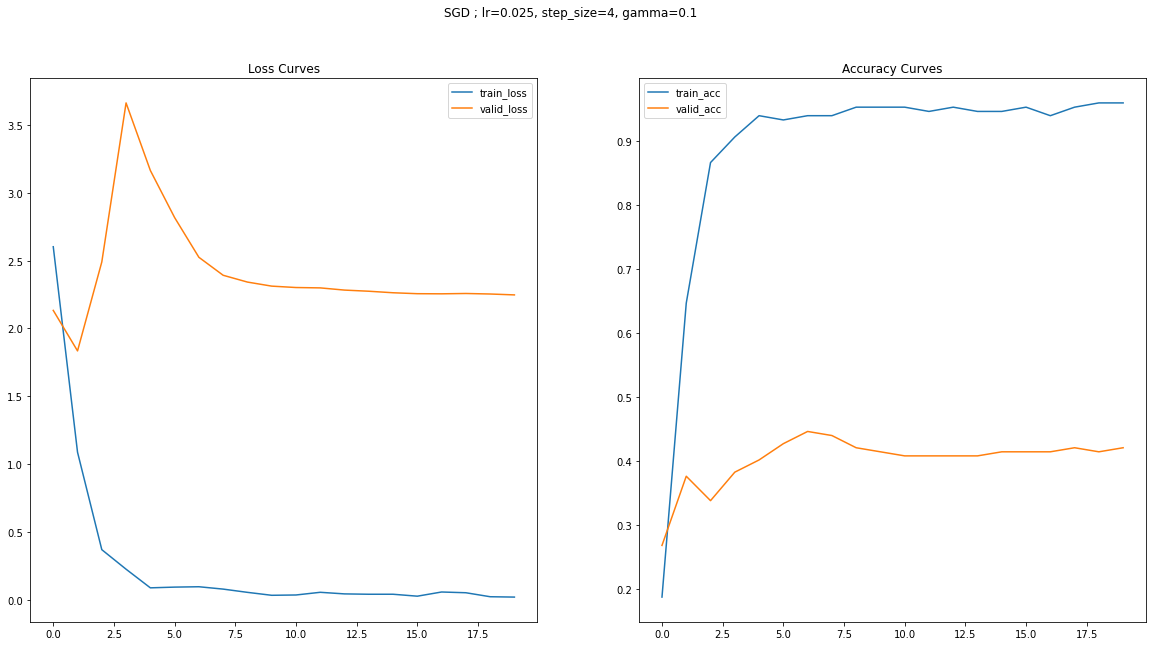

In [19]:
visualize_loss_acc(history=hist, optim=f'SGD ; lr={lr}, step_size=4, gamma=0.1')

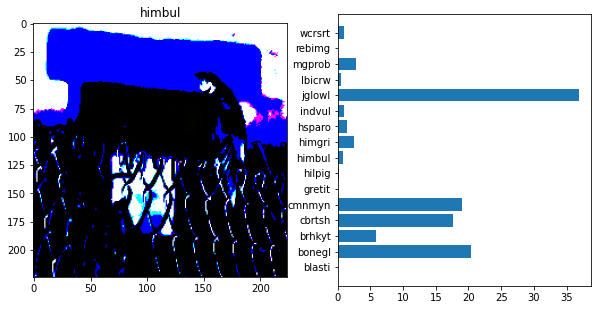

In [20]:
visualize_predict(model=model_ft, data=test_data)

Accuracy for class blasti :  0.06666666666666667
Accuracy for class bonegl :  0.0
Accuracy for class brhkyt :  0.0
Accuracy for class cbrtsh :  0.14285714285714285
Accuracy for class cmnmyn :  0.25
Accuracy for class gretit :  0.0
Accuracy for class hilpig :  0.1
Accuracy for class himbul :  0.10526315789473684
Accuracy for class himgri :  0.6
Accuracy for class hsparo :  0.5555555555555556
Accuracy for class indvul :  0.2222222222222222
Accuracy for class jglowl :  0.0
Accuracy for class lbicrw :  0.0
Accuracy for class mgprob :  0.0
Accuracy for class rebimg :  0.0
Accuracy for class wcrsrt :  0.5


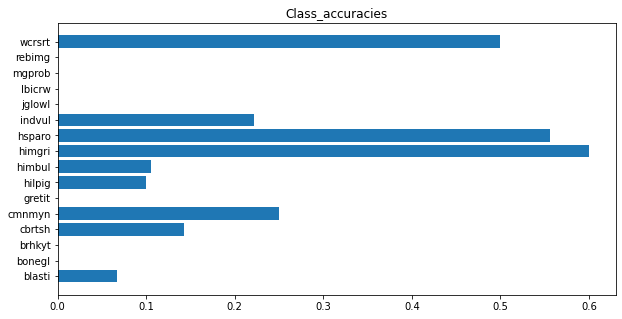

In [21]:
sgd_lr025_dict_resnet = visualize_class_accuracies(model=model_ft, data=test_data)

In [22]:
save_model(model_ft, 'resnet_best.pt')

In [23]:
# vgg
vgg, _ = initialize_model('vgg', num_classes=nc)
optimizer = optim.SGD(vgg.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
model_ft, hist = train_model(
    vgg, {'train': train_loader, 'val': test_loader}, criterion, optimizer, lr_scheduler, num_epochs=num_epochs
)

Epoch 0/19
----------
train Loss: 2.5918 Acc: 0.1267
val Loss: 2.0555 Acc: 0.3248
Epoch 1/19
----------
train Loss: 1.0901 Acc: 0.6533
val Loss: 2.0054 Acc: 0.4013
Epoch 2/19
----------
train Loss: 0.3476 Acc: 0.8733
val Loss: 2.3699 Acc: 0.4076
Epoch 3/19
----------
train Loss: 0.1087 Acc: 0.9400
val Loss: 2.6491 Acc: 0.4268
Epoch 4/19
----------
train Loss: 0.0566 Acc: 0.9400
val Loss: 2.7908 Acc: 0.4777
Epoch 5/19
----------
train Loss: 0.0558 Acc: 0.9467
val Loss: 3.0388 Acc: 0.4650
Epoch 6/19
----------
train Loss: 0.0143 Acc: 0.9600
val Loss: 3.1689 Acc: 0.4522
Epoch 7/19
----------
train Loss: 0.0250 Acc: 0.9533
val Loss: 3.2667 Acc: 0.4459
Epoch 8/19
----------
train Loss: 0.0218 Acc: 0.9533
val Loss: 3.2183 Acc: 0.4459
Epoch 9/19
----------
train Loss: 0.0122 Acc: 0.9600
val Loss: 3.2103 Acc: 0.4459
Epoch 10/19
----------
train Loss: 0.0091 Acc: 0.9600
val Loss: 3.1887 Acc: 0.4522
Epoch 11/19
----------
train Loss: 0.0077 Acc: 0.9600
val Loss: 3.1827 Acc: 0.4522
Epoch 12/19
--

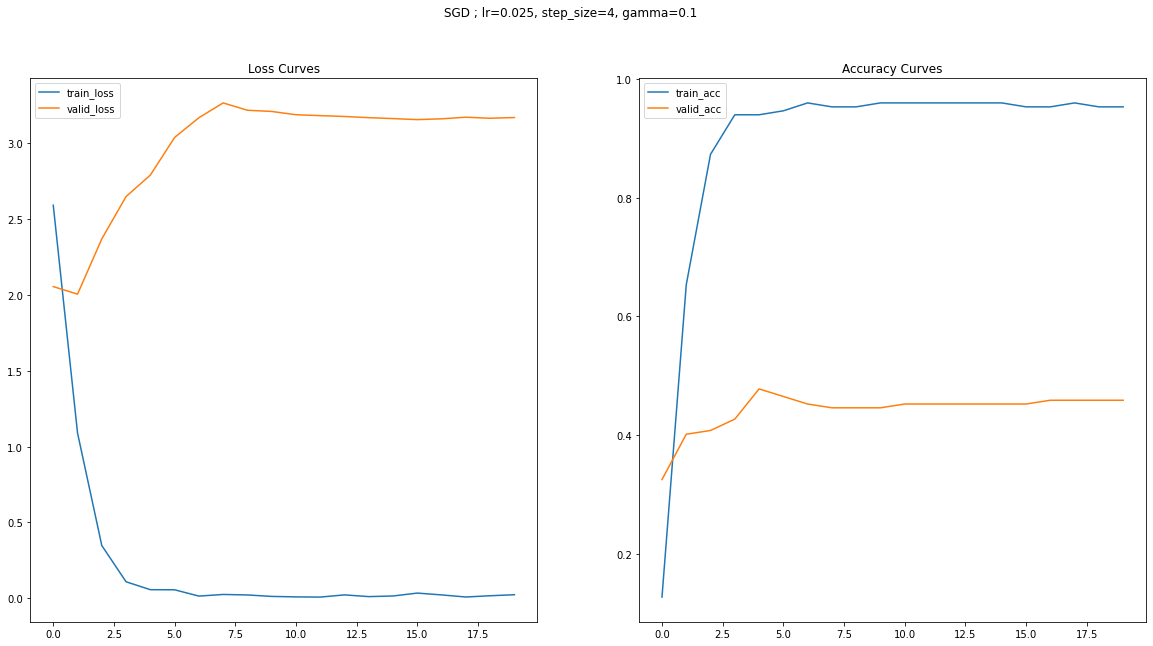

In [24]:
visualize_loss_acc(history=hist, optim=f'SGD ; lr={lr}, step_size=4, gamma=0.1')

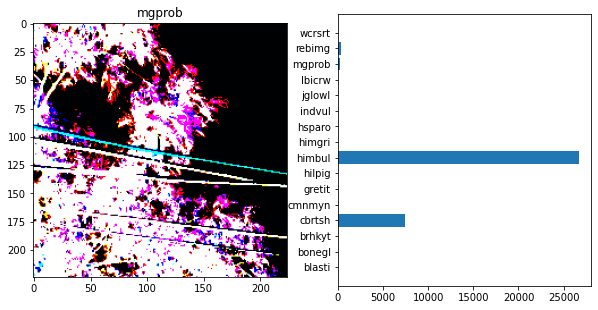

In [25]:
visualize_predict(model=model_ft, data=test_data)

Accuracy for class blasti :  0.26666666666666666
Accuracy for class bonegl :  0.0
Accuracy for class brhkyt :  0.0
Accuracy for class cbrtsh :  0.42857142857142855
Accuracy for class cmnmyn :  0.0
Accuracy for class gretit :  0.0
Accuracy for class hilpig :  0.4
Accuracy for class himbul :  0.10526315789473684
Accuracy for class himgri :  0.1
Accuracy for class hsparo :  0.4444444444444444
Accuracy for class indvul :  0.8888888888888888
Accuracy for class jglowl :  0.0
Accuracy for class lbicrw :  0.0
Accuracy for class mgprob :  0.0
Accuracy for class rebimg :  0.0
Accuracy for class wcrsrt :  0.1


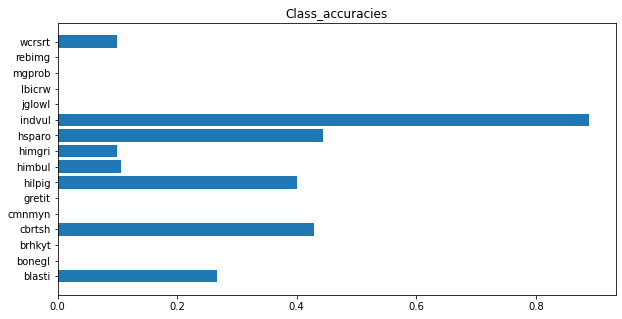

In [26]:
sgd_lr025_dict_vgg = visualize_class_accuracies(model=model_ft, data=test_data)

In [27]:
save_model(model_ft, 'vgg_best.pt')